<a href="https://colab.research.google.com/github/YogithL/Data-Science/blob/main/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

!pip install pymc-bart

import pymc_bart as pmb

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A Decision Tree is a visual representation of a model that maps different options to a final outcome. The algorithm starts at the root node and moves through a series of internal nodes based on restrictions. This process continues until it reaches a leaf node, a node with no childern that contains the final predicted value.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is how many generations, or layers, of nodes are underneath the root. Generally, the quantity, range, and complexity of your data are directly related to the depth of your tree. For instance, you wouldn't a high max depth if you only have a couple hundred data points or else your decision tree will just memorize them (overfit). On the contrary, too little layers will prevent your tree from fulling capturing the trends.

**Task4:**

How are BART models similar and different from a decision tree?

BART models are similar to decision tree's primairly because they are composed of them, so they share intrinisic traits. However, BART models are different in that they combine the results of a bunch of different trees; they do this in a sequential manner to makesure the patterns captured are different from one another.

**Task5**:

Why would we use a BART model instead of a decision tree?

I want to say we should always use BART models over decision trees because BARTs are constructed to mitigate the biggest challenge decisions trees face. Since there are so many decision trees exploring different patterns, BART models are much less prone to overfitting our data compared to a single tree.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [2]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [3]:
penguins.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


In [4]:
X = penguins[["bill_length", "bill_depth", "flipper_length"]]
Y = penguins["body_mass"].to_numpy()


In [15]:
with pm.Model() as model_penguin:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_penguin = pm.sample(compute_convergence_checks=False)


Output()

In [16]:
pm.sample_posterior_predictive(idata_penguin,model_penguin, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

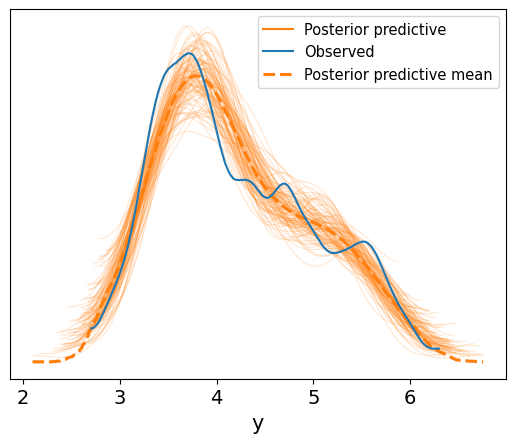

In [17]:
ax = az.plot_ppc(idata_penguin, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [18]:
X = penguins[["bill_length", "bill_depth", "flipper_length"]].to_numpy()

In [19]:
#generate the posterior predictive dist
posterior_mean = idata_penguin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_penguin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_penguin, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


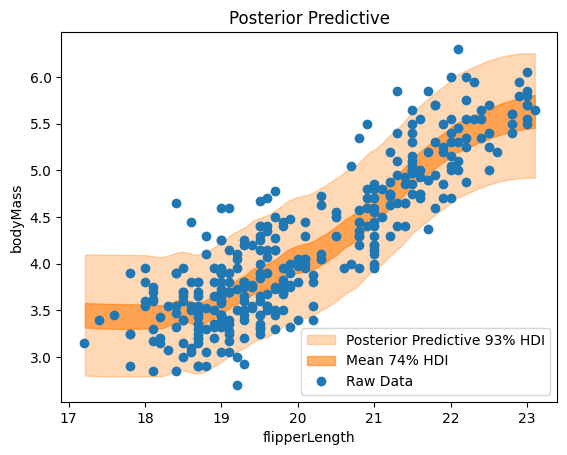

In [20]:
idx = np.argsort(X[:, 2])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 2],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X[:, 2],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipperLength",
    ylabel="bodyMass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

As flipper length increases, body mass initially rises gradually, then follows a more linear trend before eventually plateauing. From a biological stand point, the trend makes sense because there will probably be a puberty period where growth is accelerated; the data also supports this. From 17-19 units and 22-23 units the graph is much flatter compared to 19-22 units.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='X_0'>, <Axes: xlabel='X_1'>, <Axes: xlabel='X_2'>],
      dtype=object)

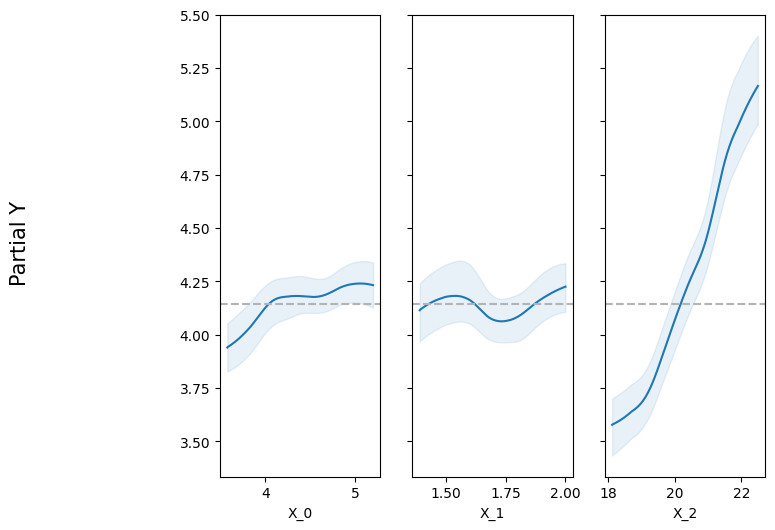

In [11]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))
#X = ["bill_length", "bill_depth", "flipper_length"]


array([<Axes: xlabel='X_0'>, <Axes: xlabel='X_1'>, <Axes: xlabel='X_2'>],
      dtype=object)

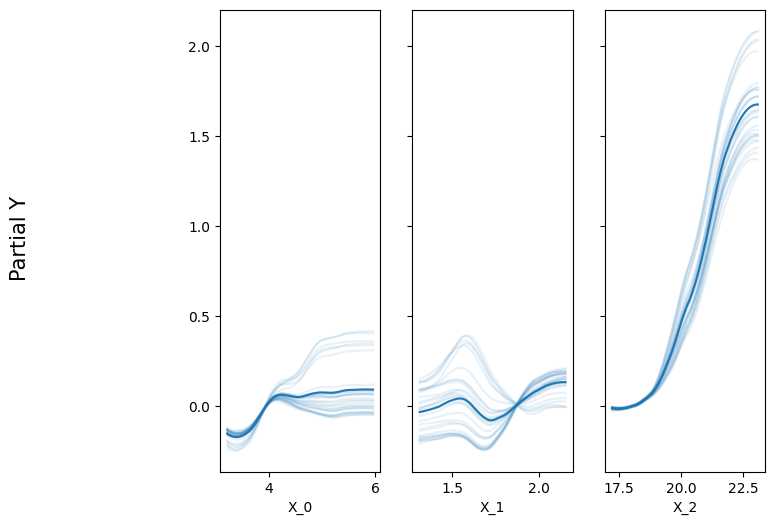

In [12]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

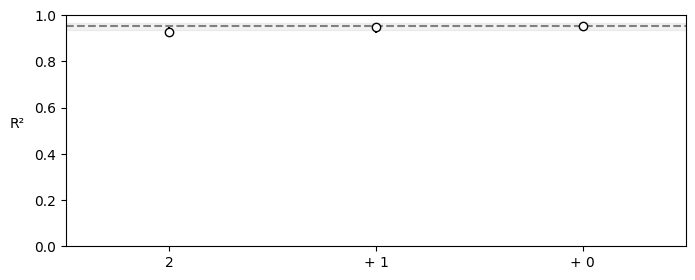

In [13]:
vi_penguin = pmb.compute_variable_importance(idata_penguin, μ_, X)
pmb.plot_variable_importance(vi_penguin)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

From the 3 plots above, FlipperLength appears to be the most significant predictor of body mass in penguins. While the VI plot doesn't pinpoint the strongest predictor, it does reveal that BillDepth and FlipperLength have a relatively (emphasis on relatively) strong impact on R^2. Then, through the PDP, it's clear to see that FlipperLength has the most direct correlation with body mass. In contrast, BillLength and BillDepth's relationship with Body Mass varies across the x-axis; both exhibit negative and positive correlations (as seen in the ICE plot). Therefore, potential interactions with FlipperLength could be at play.